In [152]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import models
import util
import os
import config
from config import ATTR_TO_INDEX
import viz
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import seaborn as sns
import data
import sklearn.metrics
from matching import *

DIR_ORIG = '../data/celeba-hq/ims/'
DIR_GEN = oj('../data_processed/celeba-hq/generated_images_0.1')


# df contains filenames, ids, and attributes
df = data.load_all_labs()
df = df.set_index('fname_id')
df = df.loc[fname_ids]
df = df[['id', 'fname_final', 'age', 'gender', 'race_pred', 'Eyeglasses']] # only keep few keys to speed things up

# get fnames
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f] # these start at 00001
fnames_calculated = np.array([f[:-4] for f in fname_nps]) # these start at 00001
idxs_calculated = np.array([int(x) - 1 for x in fname_ids]) # this starts at 0

# load latents and calculate dists
print('reload latents...')
latents = np.array([np.load(oj(DIR_GEN, f)) for f in fname_nps])
lats = get_lat(latents)
preds = np.ones((lats.shape[0], 6)) #lats @ coefs.T + intercepts.T
weights = np.ones(preds.shape[1])
# print(ATTR_TO_INDEX)
# weights[ATTR_TO_INDEX['skin-color']] = 1e2
vecs = join_vecs(preds, lats, weights)
print('calculating gan dists...')
dists_gan = get_dists(vecs)
print('done!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading cached labels
reload latents...
calculating gan dists...
done!


In [125]:
# load pairwise facial dicts
print('load facial dists')
dists_facial = np.load(open('processed/13_facial_dists_pairwise.npy', 'rb')) # pkl.load()
dists_facial = dists_facial[idxs_calculated]
dists_facial = dists_facial[:, idxs_calculated]
print('facial dists loaded')

load facial dists
facial dists loaded


# find best matches

In [154]:
'''
we want to find matched pairs
the pairs should change only one attribute at a time (but we may vary 2 to make a transect)
"main" image is matched stringently
"reference" image is matched more loosely
'''


# specify dists for matching
dists_match = dists_facial
dists_ref = dists_gan
n = dists_match.shape[0]
assert df.shape[0] == n

# specify things to vary (these should all be binary columns)
# id willl automatically be different when we vary gender, race bc these things 
# are forced to be preserved in data.py
attrs_to_vary = ['gender'] # Eyeglasses, gender, Race


# specify constraint for reference
def apply_reference_constraints(d):
    REFERENCE_CONSTRAINTS = {
        'Eyeglasses': 0, # default should be no Eyeglasses
    }
    for k in REFERENCE_CONSTRAINTS.keys():
        d = d[d[k] == REFERENCE_CONSTRAINTS[k]]
    return d

## select only ims with a reference image satisfying reference constraints
def get_idxs_satisfying_reference_constraints(df, n):
    df['bool'] = 1
    idxs_orig = df['bool'] # np.ones(n).astype(bool)
    df = df.drop(columns='bool')
    for i in tqdm(sorted(df.id.unique())):
        d = df[df.id == i]

        # if there is only one photo for this id, don't pick it
        if d.shape[0] == 1:
            idxs_orig.loc[d.index] = False
        
        else:
            # look for valid ref photos
            d_ref = apply_reference_constraints(d)

            # if there is no valid ref, don't pick any image with this id
            if d_ref.shape[0] < 1:
                idxs_orig.loc[d.index] = False

            # if there is 1 valid ref, don't pick the reference image
            # (we can still pick a different photo with this id)
            elif d_ref.shape[0] == 1:
                idxs_orig.loc[d_ref.index] = False 
    return idxs_orig.values.astype(bool)

idxs_orig = get_idxs_satisfying_reference_constraints(df, n)



  0%|          | 0/4744 [00:00<?, ?it/s]

  1%|          | 33/4744 [00:00<00:14, 325.84it/s]

  1%|▏         | 67/4744 [00:00<00:14, 329.08it/s]

  2%|▏         | 101/4744 [00:00<00:13, 331.81it/s]

  3%|▎         | 134/4744 [00:00<00:13, 331.24it/s]

  4%|▎         | 169/4744 [00:00<00:13, 335.63it/s]

  4%|▍         | 204/4744 [00:00<00:13, 338.99it/s]

  5%|▍         | 236/4744 [00:00<00:13, 332.51it/s]

  6%|▌         | 272/4744 [00:00<00:13, 338.56it/s]

  6%|▋         | 308/4744 [00:00<00:12, 341.73it/s]

  7%|▋         | 344/4744 [00:01<00:12, 345.15it/s]

  8%|▊         | 381/4744 [00:01<00:12, 349.69it/s]

  9%|▉         | 416/4744 [00:01<00:12, 346.63it/s]

 10%|▉         | 452/4744 [00:01<00:12, 348.44it/s]

 10%|█         | 488/4744 [00:01<00:12, 348.69it/s]

 11%|█         | 524/4744 [00:01<00:12, 350.68it/s]

 12%|█▏        | 559/4744 [00:01<00:12, 347.75it/s]

 13%|█▎        | 594/4744 [00:01<00:12, 339.92it/s]

 13%|█▎        | 628/4744 [00:01<00:12, 332.05it/s]

 14%

In [155]:
np.sum(idxs_orig)

14548

In [156]:
idxs_orig

array([ True,  True,  True, ...,  True,  True,  True])

In [157]:
# find allowed indices for each group
subgroups = {}
for a in attrs_to_vary:
    for val in [0, 1]:
        subgroups[f'{a}_{val}'] = (df[a].values == val) & idxs_orig

matches = []
for match_num in tqdm(range(10)):
    # loop to create best matches
    for i, a in enumerate(attrs_to_vary):
        # this should go in order from smaller groups -> bigger groups
    #     vals = np.argsort([np.sum(subgroups[f'{a}_{val}']) for val in [0, 1]])
    #     for j, val in enumerate([0, 1]):

        ## find best match subject to constraints
        s0 = f'{a}_{0}'
        s1 = f'{a}_{1}'
        idxs0 = subgroups[s0]
        idxs1 = subgroups[s1]
        C = np.sum(idxs1)
        dists_constrained = dists_match[idxs0][:, idxs1] # (R, C)
        arg = np.argmin(dists_constrained)

        # convert match arg back to space without constraints
        arg0 = arg // C
        arg1 = arg % C
        idx0 = np.where(idxs0)[0][arg0]
        idx1 = np.where(idxs1)[0][arg1]

        ## find reference images
        df0 = df.drop(df.index[idx0])[df.id == df.iloc[idx0].id]
        df1 = df.drop(df.index[idx1])[df.id == df.iloc[idx1].id]
        assert df0.shape[0] > 0 and df1.shape[0] > 0, 'must have valid reference images'
        
        ## compare differences for reference images
        # dists_ref_constrained = dists_ref[][]
        
        ## if best reference image isn't great, then continue
        

        ## save the pairs
        matches.append({
            s0: idx0,
            s1: idx1,
            'dist': dists_constrained[arg0, arg1]
        })

        ## remove them from further consideration
        subgroups[s0][idx0] = False
        subgroups[s1][idx1] = False



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:02<00:22,  2.45s/it]

 20%|██        | 2/10 [00:05<00:20,  2.62s/it]

 30%|███       | 3/10 [00:07<00:17,  2.44s/it]

 40%|████      | 4/10 [00:10<00:15,  2.63s/it]

 50%|█████     | 5/10 [00:12<00:12,  2.44s/it]

 60%|██████    | 6/10 [00:15<00:09,  2.44s/it]

 70%|███████   | 7/10 [00:17<00:07,  2.45s/it]

 80%|████████  | 8/10 [00:19<00:04,  2.40s/it]

 90%|█████████ | 9/10 [00:21<00:02,  2.31s/it]

100%|██████████| 10/10 [00:24<00:00,  2.40s/it]


/home/ubuntu/face-disentanglement/src/util.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, N_IMS, N_IMS // 2 + 1)


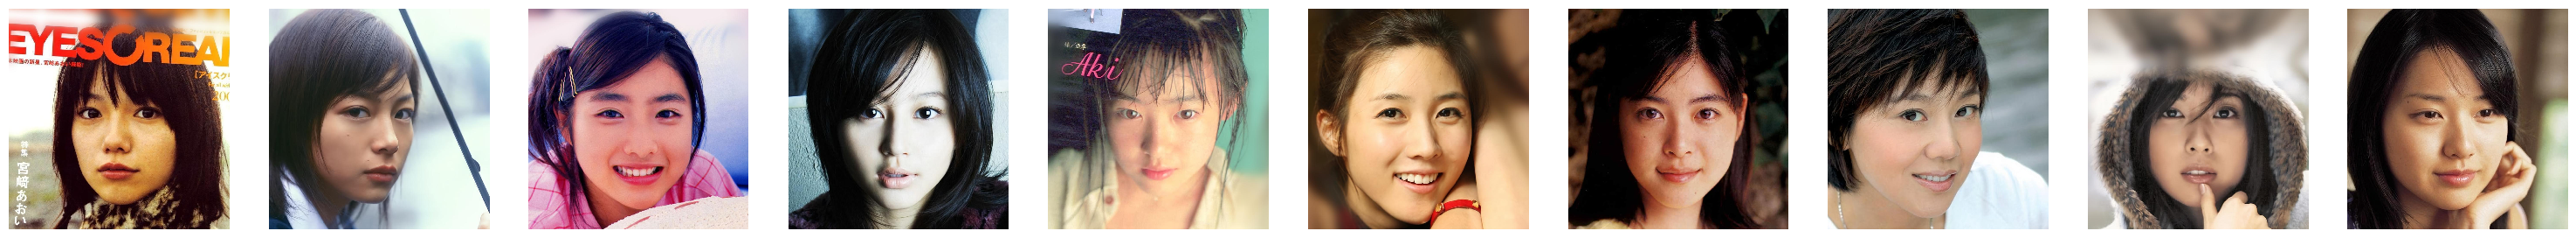

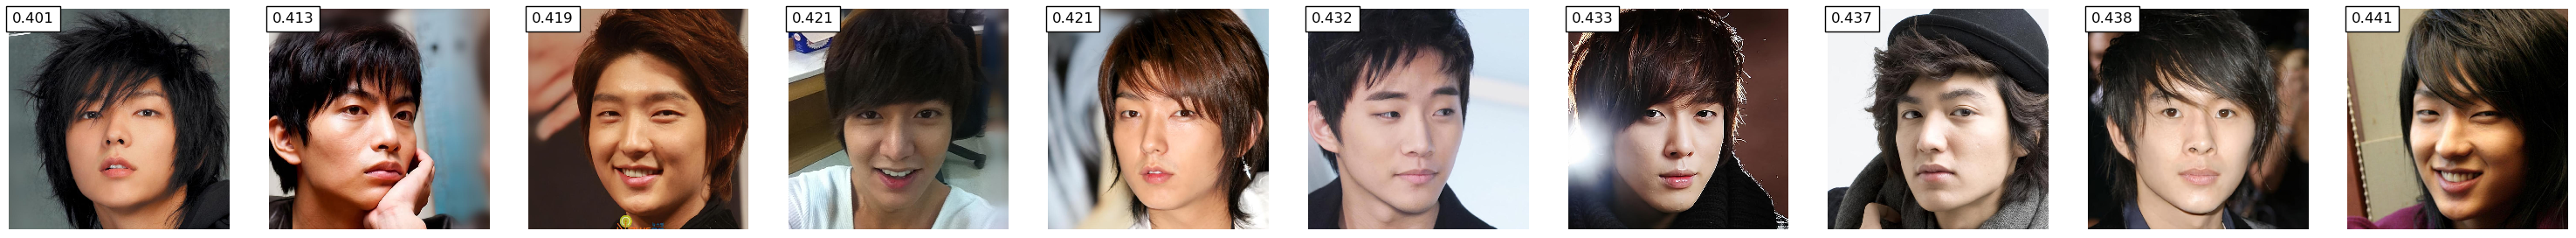

In [158]:
ims0 = []
ims1 = []
dist_list = []
for match in matches:
    a = 'gender'
    idx0 = match[f'{a}_0']
    idx1 = match[f'{a}_1']
    d0 = df.iloc[idx0]
    d1 = df.iloc[idx1]
    ims0.append(mpimg.imread(oj(DIR_ORIG, d0.fname_final)))
    ims1.append(mpimg.imread(oj(DIR_ORIG, d1.fname_final)))
    dist_list.append(match['dist'])
util.plot_row(ims0)
util.plot_row(ims1, annot_list=np.array(dist_list).round(3))